# Project Introduction 
This is my project in a data mining course. It is to predict bike flows with K-nearest neighbors (kNN).

Hubway, is a bike sharing system (BSS) available in Boston. A common problem faced by a sharing system is unbalanced supply and demand. We aim to predict on flow of incoming bikes as well as outgoing bikes given a particular station, date and time frame.

To approach this problem, we decided to find similar days of a given date. From there, we predict the proportion of bikes goint from/to the given station. Since we have information on capacity of a station, we can get the number of bikes. 

1. [Explore the Datasets](kNN-on-traffic-prediction.ipynb#1.-Explore-the-Datasets)
2. [What is kNN](kNN-on-traffic-prediction.ipynb#2.-What-is-kNN)
3. [Distance Function](kNN-on-traffic-prediction.ipynb#3.-Distance-Function)
4. [Nearest Neighbors](kNN-on-traffic-prediction.ipynb#4.-Nearest-Neighbors)
5. [Estimation](kNN-on-traffic-prediction.ipynb#5.-Estimation)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt
import operator

import numpy.linalg as la
import matplotlib.pyplot as plt

from collections import OrderedDict

# 1. Explore the Datasets

There are three datasets we use:
1. bike trip data 
2. station capacity
3. weather data

The first two are available from hubwaydatachallenge (http://hubwaydatachallenge.org), and the weather data is scrapped from https://www.wunderground.com

## bike trip data 

Trip data recorded trips themselves (date, start station, end station) and the user (age, sex) if they were registered.

In [2]:
############## trips ##############
trip_df = pd.read_csv('./data/hubway_trips.csv')

print trip_df.head()

   seq_id  hubway_id  status  duration          start_date  strt_statn  \
0       1          8  Closed         9  7/28/2011 10:12:00        23.0   
1       2          9  Closed       220  7/28/2011 10:21:00        23.0   
2       3         10  Closed        56  7/28/2011 10:33:00        23.0   
3       4         11  Closed        64  7/28/2011 10:35:00        23.0   
4       5         12  Closed        12  7/28/2011 10:37:00        23.0   

             end_date  end_statn bike_nr  subsc_type zip_code  birth_date  \
0  7/28/2011 10:12:00       23.0  B00468  Registered   '97217      1976.0   
1  7/28/2011 10:25:00       23.0  B00554  Registered   '02215      1966.0   
2  7/28/2011 10:34:00       23.0  B00456  Registered   '02108      1943.0   
3  7/28/2011 10:36:00       23.0  B00554  Registered   '02116      1981.0   
4  7/28/2011 10:37:00       23.0  B00554  Registered   '97214      1983.0   

   gender  
0    Male  
1    Male  
2    Male  
3  Female  
4  Female  


Let's check the range of the trips

In [3]:
print pd.to_datetime(trip_df['start_date'], format='%m/%d/%Y %H:%M:%S').min()
print pd.to_datetime(trip_df['start_date'], format='%m/%d/%Y %H:%M:%S').max()

2011-07-28 10:12:00
2013-11-30 23:39:00


Slightly more than two-year data we got here. Not much, but good enough.

We consider date and time separately.  

In [4]:
trip_df['start_time'] = trip_df['start_date'].apply(lambda l: l.split(' ')[1])
trip_df['start_date'] = trip_df['start_date'].apply(lambda l: l.split(' ')[0])
trip_df['end_time'] = trip_df['end_date'].apply(lambda l: l.split(' ')[1])
trip_df['end_date'] = trip_df['end_date'].apply(lambda l: l.split(' ')[0])

print trip_df.head()

   seq_id  hubway_id  status  duration start_date  strt_statn   end_date  \
0       1          8  Closed         9  7/28/2011        23.0  7/28/2011   
1       2          9  Closed       220  7/28/2011        23.0  7/28/2011   
2       3         10  Closed        56  7/28/2011        23.0  7/28/2011   
3       4         11  Closed        64  7/28/2011        23.0  7/28/2011   
4       5         12  Closed        12  7/28/2011        23.0  7/28/2011   

   end_statn bike_nr  subsc_type zip_code  birth_date  gender start_time  \
0       23.0  B00468  Registered   '97217      1976.0    Male   10:12:00   
1       23.0  B00554  Registered   '02215      1966.0    Male   10:21:00   
2       23.0  B00456  Registered   '02108      1943.0    Male   10:33:00   
3       23.0  B00554  Registered   '02116      1981.0  Female   10:35:00   
4       23.0  B00554  Registered   '97214      1983.0  Female   10:37:00   

   end_time  
0  10:12:00  
1  10:25:00  
2  10:34:00  
3  10:36:00  
4  10:37:00  


## station capacity

Capacity data contains capcity of the stations for each day

We'll want to build a function that returns the capacity of an station at any given day.

In [5]:
############## capacity ##############
df = pd.read_csv('./data/stationstatus.csv', usecols=['station_id', 'update','capacity'])
df.head()

,station_id,update,capacity
0,3,2011-08-22 16:23:33.557-04,17
1,5,2011-08-22 16:23:33.557-04,15
2,6,2011-08-22 16:23:33.557-04,15
3,8,2011-08-22 16:23:33.557-04,15
4,9,2011-08-22 16:23:33.557-04,19


In [6]:
df['update'] = df['update'].apply(lambda l: l.split(' ')[0])
capacity_df = df.groupby(['station_id', 'update']).max()

print capacity_df.head()

                       capacity
station_id update              
3          2011-08-22        17
           2011-08-23        17
           2011-08-24        17
           2011-08-25        17
           2011-08-26        16


In [7]:
avg_cap = capacity_df['capacity'].mean()

print avg_cap

15.8414278195


In [8]:
def get_cap(stn, date):
    if stn in capacity_df.index:        
        try:
            cap = capacity_df.loc[stn].loc[date]['capacity']
        except:
            cap = capacity_df.loc[stn].mean()
    else:
        cap = avg_cap
    return cap

If the capacity of a station at the given day exists, we find the capacity. Elsewise, estimate the capacity by the average capacity of all stations. 

Like below:

In [9]:
print get_cap(33, '2012-09-30')
print get_cap(180, '2012-09-30')

19
15.8414278195


## weather data

The weather data contains information on minimum, maximum temperature and precipitation for each day in Boston.

We further added weekday and season information to the weather data. The preparation of weather data is skipped here. Let's use it as a readily available one. 

In [10]:
############## weather ##############
weather = pd.read_csv('./data/weatherBoston.csv')
print weather.head()

        date  weekday  season           weather  max_temp  min_temp  \
0  7/28/2011        1  summer  Scattered Clouds        24        20   
1  7/29/2011        1  summer              Rain        26        19   
2  7/30/2011        0  summer     Partly Cloudy        32        23   
3  7/31/2011        0  summer  Scattered Clouds        33        21   
4   8/1/2011        1  summer     Partly Cloudy        34        22   

  precipitation  
0             0  
1          3.56  
2             0  
3             0  
4             0  


Weather data requires a bit of cleaning.

The precipitation is of mixed types as shown here.

In [11]:
print weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 7 columns):
date             857 non-null object
weekday          857 non-null int64
season           857 non-null object
weather          857 non-null object
max_temp         857 non-null int64
min_temp         857 non-null int64
precipitation    857 non-null object
dtypes: int64(3), object(4)
memory usage: 46.9+ KB
None


So we firstly convert the precipitation column to numeric one. And then fill the null entries with average precipitation

In [12]:
# precipitation: str to numeric
weather.precipitation = weather.precipitation.apply(pd.to_numeric, errors='coerce')
print weather.precipitation.isnull().sum()
avg = weather.precipitation.mean()
print avg

92
2.95878431373


In [13]:
# precipitation: fill up the null value with average precipitation
weather.precipitation = weather.precipitation.fillna(avg)
print weather.precipitation.isnull().sum()

0


# 2. What is kNN

The idea behind kNN algorithm is to predict unknown values based on the most similar known values.

Taking computer purchase as an example, a computer's performance is largely determined by its configurations. If you know there is a good product, you are likely to look for similar configurations in order to to get a good one. 

kNN is as straightforward as that. 

In our problem, to predict bike flow between stations, we introduced weather as attributes for trips. Think in this way, a trip decision (i.e. to rent and ride a bike), is largely dependent on the traffic condition (i.e. peak hour or not) and the day condition (i.e rainy or sunny).

It draws down to find similar values -- we can use weather to find similar days, and subset on trips dataset accordingly to find similar trips.  

Again, it is back to the idea of predicting unknown values based on the most similar known values.

To understand and impolement kNN, the algorithm breaks down to:
1. Distance -- How to define similar days?
2. Nearest Neighbors -- How to subset trips on neighboring days based on distance in 1
3. Estimation -- How to predict unknown using known values in 2

Let's walk through it one by one

# 3. Distance Function

Let's setup our input values first

In [14]:
########### parameters ##############
# creates a day and a timeframe
dateInput = '9/4/2012'
timeFrameStart = "10:00:00"
timeFrameEnd = "12:00:00"
# tell which station you are interested in
stn = 33
# 20 is the number of nearest neighbor we consider
k = 20
# this is the average capacity of a staion calculated earlier
avgCapa = 15.84

The we need a list of candidates. Here we extract list of days from the trip data. Basically this is the scope of estimation. We don't want to have days outside of the known trips, because that will not bring any known information to help the prediction.

In [15]:
## creates a list with all the days (used for the KNN algo)
mask = (trip_df['start_time'] >= timeFrameStart) \
     & (trip_df['end_time'] <= timeFrameEnd) \
     & (trip_df['strt_statn'] == stn) \
     & (trip_df['start_date'] == trip_df['start_date']) \
     & (trip_df['start_date'] != dateInput)

day_list = list(weather['date'].values)

Now, let's find K nearest neighbors to a day in the list of all the days

What makes a day similar? We want to define our distance between two days as the following:
1. the distance is close to infinity if they are not both weekdays or weekend;
2. the closer the days are in time, the smaller the distance is;
3. the closer the minimum and maximum temperatures are, the smaller the distance is;
4. a difference of 4 degrees has the same impact on the distance as a one year difference.

Elsewise, you can consider Euclidean distance, which is simply a sum of squared distances of each attribute. Here we construct our distance function to suit our problem. Nevertheless, the key is to come up with a distance measurement so as to quantify similarity. 

In [16]:
def kNN(date, k):
    # initiation
    dist_list = []
    neighbors = []
    date_weather = weather[weather['date'] == date]

    # distance specifications
    weekday_dist = 50000
    season_dist = 1000
    day_dist = 100
    
    for day in day_list:
        if day != date:
            distance = 0
            compare_weather = weather[weather['date'] == day]   
            if int(date_weather['weekday'].iloc[0]) != int(compare_weather['weekday'].iloc[0]):
                distance += weekday_dist
            if date_weather['season'].iloc[0] != compare_weather['season'].iloc[0]:
                distance += season_dist
            timeDif = (dt.datetime.strptime(date, '%m/%d/%Y') - dt.datetime.strptime(day, '%m/%d/%Y')).days / float(day_dist)
            max_temp_Dif = date_weather['max_temp'].iloc[0] - compare_weather['max_temp'].iloc[0]
            min_temp_Dif = date_weather['min_temp'].iloc[0] - compare_weather['min_temp'].iloc[0]
            prec_Dif = date_weather['precipitation'].iloc[0] - compare_weather['precipitation'].iloc[0]

            distance += timeDif * timeDif
            distance += max_temp_Dif * max_temp_Dif * 2
            distance += min_temp_Dif * min_temp_Dif * 2
            distance += prec_Dif * prec_Dif

            dist_list.append((day, distance))

    dist_list.sort(key=operator.itemgetter(1))
    for i in range(k):
        neighbors.append((dist_list[i][0]))
    return neighbors

This function gives us the k-nearest days of the given day.

The neighboring days are pretty much cyclical. This is understandable. Days consecutive are most likely to be similar, and days around the same season in different years can be similar.

In [17]:
kNN_days = kNN(dateInput, k)
print kNN_days

['7/31/2012', '9/13/2013', '6/28/2013', '9/6/2011', '9/19/2012', '7/29/2013', '7/25/2013', '9/7/2012', '6/27/2012', '8/22/2011', '9/2/2013', '7/9/2013', '8/13/2013', '9/5/2012', '8/8/2011', '8/10/2011', '6/26/2012', '9/18/2012', '9/7/2011', '7/29/2011']


# 4. Nearest Neighbors

Now we have got a list of similar days. 

We can use similar days to subset the trip data to get similar trips. 

And that would be the nearest neighbors of a trip that we want to predict.

In [18]:
# find the trips that comes from the station, at similar days, similar times
# filter out the give dateInput as you don't want to predict on the same data
mask = (trip_df['start_date'].isin(kNN_days)) \
     & (trip_df['start_time'] >= timeFrameStart) \
     & (trip_df['end_time'] <= timeFrameEnd) \
     & (trip_df['strt_statn'] == stn) \
     & (trip_df['start_date'] == trip_df['start_date']) \
     & (trip_df['start_date'] != dateInput)

to_trips = trip_df[mask]
print to_trips.head()

        seq_id  hubway_id  status  duration start_date  strt_statn   end_date  \
12204    12205      13402  Closed       619  8/10/2011        33.0  8/10/2011   
12205    12206      13403  Closed      1239  8/10/2011        33.0  8/10/2011   
28369    28370      31587  Closed     20670  8/22/2011        33.0  8/23/2011   
45661    45662      52504  Closed       152   9/6/2011        33.0   9/6/2011   
299320  299321     340929  Closed       375  6/26/2012        33.0  6/26/2012   

        end_statn bike_nr  subsc_type zip_code  birth_date  gender start_time  \
12204        14.0  B00293  Registered   '02134      1978.0    Male   10:27:00   
12205        23.0  B00286  Registered   '02215      1965.0  Female   10:28:00   
28369        53.0  B00300      Casual      NaN         NaN     NaN   20:27:00   
45661        10.0  B00188  Registered   '01462      1981.0    Male   11:41:00   
299320        9.0  B00605  Registered   '02215      1981.0    Male   10:07:00   

        end_time  
12204  

# 5. Estimation

Two common methods to deal with kNN predictions are regression and averaging. 

Among the two, I personally prefer averaging. Especially you can come up with your rules on combining the results such as:
* Majority vote
* Distance weighted vote

In our project, we finally used regression as time is progressive.

No matter what method is used, the idea is still to rely on the predictions of the k examples

## Linear Regression

Do a regression of proportion of outgoing bikes on time. 

First we fit the list of similar days to numerical ones. This is our x variable.

In [19]:
kNN_dates = []
for ele in kNN_days:
    kNN_dates.append(dt.datetime.strptime(ele, '%m/%d/%Y'))
kNN_dates = np.sort(kNN_dates)

timeArray = [0]
for i in range(1, len(kNN_dates)):
    timeArray.append(timeArray[i-1] + (kNN_dates[i] - kNN_dates[i-1]).days)
print timeArray

[0, 10, 12, 24, 39, 40, 333, 334, 368, 404, 406, 417, 418, 700, 711, 727, 731, 746, 766, 777]


Then construct the corresponding dependent variable which is a list of proportion of outgoing bikes by day. 

The proportion is the total trips made divided by the capacity of the station

In [20]:
## calculate the number of trip comes from the station per day
tripPerDay = to_trips[['start_date', 'hubway_id']].groupby('start_date').count()
print tripPerDay.head()

            hubway_id
start_date           
6/26/2012           4
6/27/2012           4
6/28/2013           3
7/25/2013           4
7/29/2013           4


In [21]:
# get the corresponding number of trip array
# tripArray: number of trips divided by the capacity of the station at that day 
tripArray = []
for day in kNN_days:
    try:
        num_trips = tripPerDay.loc[day]['hubway_id']
        cap = get_cap(stn, day)
        tripArray.append(num_trips / float(cap))
    except:
        tripArray.append(0)

print tripArray

[0.17130846032580138, 0.45682256086880368, 0.17130846032580138, 0.057102820108600461, 0.57102820108600461, 0.22841128043440184, 0.22841128043440184, 0.68523384130320553, 0.22841128043440184, 0.057102820108600461, 0.74233666141180599, 0.62813102119460507, 0.2855141005430023, 0.17130846032580138, 0, 0.11420564021720092, 0.22841128043440184, 0.39971974076020322, 0, 0]


Now we have x and y variables. Let's write a linear regression function. 

In [22]:
## do a regression on that
## does the linear regression of the Yarray(timeArray) and display the result if plot
def linearRegression(XArray, YArray, plot):
    coef = np.polyfit(XArray, YArray, 1)
    p = np.poly1d(coef)
    # err
    err = 0
    estim = []
    for i in range(len(XArray)):
        estim.append(p(XArray[i]))
        err += (estim[i] - YArray[i]) * (estim[i] - YArray[i])
    
    if plot:
        #_ = plt.plot(time, trips, '.', xp, p(xp), '-')
        plt.plot(XArray, YArray, 'ro', XArray, p(XArray), '--k')
        
        plt.ylim(-1, 1)
        plt.show()
    
    return coef, err

The result and visualization of the regression output is as following:

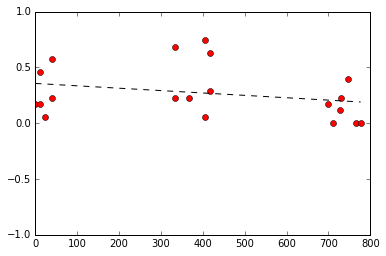

In [23]:
coef, err = linearRegression(timeArray, tripArray, True)

In [24]:
print coef, err 

[ -2.13723720e-04   3.56332495e-01] 0.959659487748


We can now predict with the fitted line. 

Get the timestamp of the studied day in the same space as our time array, and estimate the proportion of outgoing bikes of the studied day. 

In [25]:
newDay = (dt.datetime.strptime(dateInput, '%m/%d/%Y') - kNN_dates[0]).days
print newDay

403


In [26]:
# estimation
p = np.poly1d(coef)
print p(newDay)

0.270201835473


Multiply the proportion with the station's capacity. This is the estimation of outgoing bikes for the studied station and time period.

In [27]:
print np.floor(p(newDay) * get_cap(stn, dateInput)['capacity'] + 0.5)

5.0


What is the actual number of trips?

In [28]:
mask = (trip_df['strt_statn']==stn) \
     &(trip_df['start_date']==dateInput) \
     & (trip_df['start_time'] >= timeFrameStart) \
     & (trip_df['end_time'] <= timeFrameEnd)
print trip_df[mask].end_statn.shape[0]

5


Not bad :)

## Averaging


Averaging is simply find the average proportion of outgoing bikes for the list of similar days. 

Our project used regression. So here I just put a line for demonstration. 

In [29]:
print np.floor(np.mean(tripArray) * get_cap(stn, dateInput)['capacity'] + 0.5)

5.0


# What Happened After
1. The incoming flow of bikes to a station is also estimated. It uses the same method so is skipped in this notebook
2. The value of k has to be adjusted (crossvalidation)
    * can overfit (k too low) 
    * can underfit (k too high)
    * in the school project, we did come to the conclusion of k=10 as the optimal through crossvalidation
3. Several evaluations are constructed
    * measure 1: the percentage of correct predictions for all the stations;
    * measure 2: 1 minus the mean absolute percentage error (MAPE) for stations with non-zero predicted bike flow
    * measure 3: the ratio of the total predicted flow over actual flow in the system, stratified by positive flow and negative flow.
    * The above 1 to 1 comparison on prediction and actual results are merely an illustration.

And finally, we did get a good grade in this course. Hurray!